# Transfer Learning for Image Classification




## 1) Load & Understand the Dataset


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

In [ ]:
#Fetch Data
raw_dataset = CIFAR10(root='./data', train=True, download=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 25351710.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
#See labels
class_names = raw_dataset.classes
print(len(class_names))
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


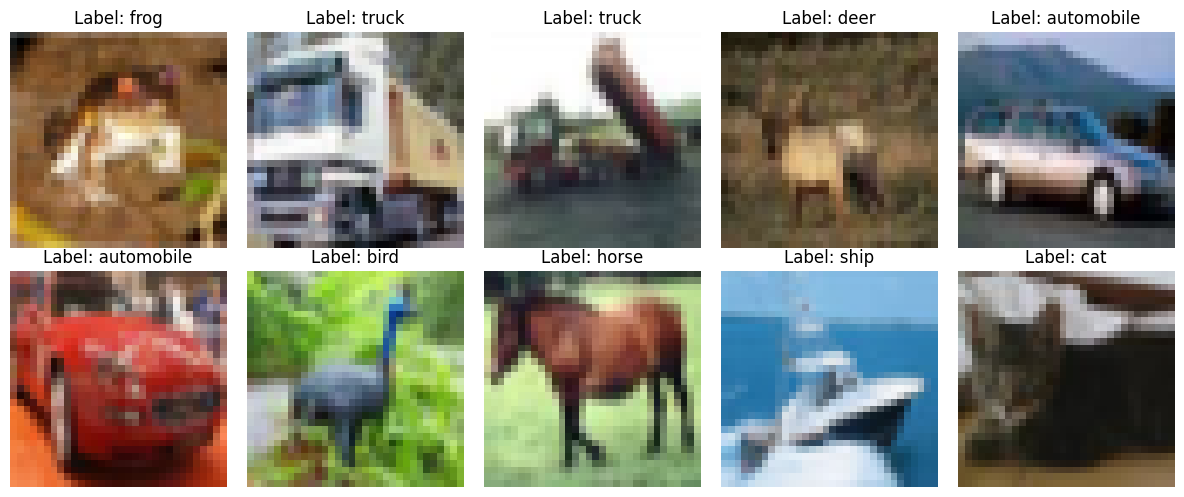

In [ ]:
#Display some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.ravel()):
    img, label = raw_dataset[i]
    ax.imshow(img)
    ax.set_title(f'Label: {class_names[label]}')  # Use class_names to get the label name
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#See label distributions
label_counts = {class_name: 0 for class_name in class_names}
for _, lbl in raw_dataset:
    label_counts[class_names[lbl]] += 1

print("Label Distributions:", label_counts)

Label Distributions: {'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


In [ ]:
# Basics about the dataset
print(f"Data type of images: {type(raw_dataset[0][0])}")
print(f"Data type of labels: {type(raw_dataset[0][1])}")
print(f"Shape of an image: {raw_dataset[0][0].size}")

Data type of images: <class 'PIL.Image.Image'>
Data type of labels: <class 'int'>
Shape of an image: (32, 32)


## 2) Split & Pre-process Data



In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Split data
train_len = int(0.8 * len(train_dataset))
valid_len = len(train_dataset) - train_len
train_subset, valid_subset = random_split(train_dataset, [train_len, valid_len])

In [ ]:
#Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 3) Model Setup



In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
import time

### 3.1) Define the Model


In [ ]:
class VGG16Transfer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16Transfer, self).__init__()
        self.base_model = vgg16(pretrained=True) #gets the pre-trained weights
        self.base_model.features.requires_grad_(False) #no backprop. on Conv. Layers

        num_features = self.base_model.classifier[0].in_features #the output of the Conv. Layers

        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

        self.base_model.classifier = self.classifier #adds classfier to model

    def forward(self, x):
        return self.base_model(x) #Forward pass through the entire model

### 3.1) Define a Training Function


In [ ]:
def train_one_epoch(model, optimizer, criterion, train_loader):

    model.train()

    #initialize metrics
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader: #iterates over batches
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad() #clears gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #computes gradient of the loss
        optimizer.step() #updates model's paramaters

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

### 3.1) Define a Validation / Testing Function


In [ ]:
def validate(model, criterion, valid_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): #no gradient desc.
        for inputs, labels in valid_loader: #iterates over batches
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(valid_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## 4) Tune the Hyper-Parameters



In [ ]:
results = {}
LEARNING_RATES = [0.001, 0.01]
OPTIMIZERS = ['Adam', 'SGD Momentum']
EPOCHS=10


for lr in LEARNING_RATES:
    for opt in OPTIMIZERS:
        print(f"Training with LR = {lr} and Optimizer = {opt}")

        model = VGG16Transfer(num_classes=10).cuda()

        if opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'SGD Momentum':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        train_accs = []
        valid_accs = []

        patience = 3  # No of epochs with no improvement on valid. loss to wait before termination
        stopping_counter = 0  # To keep track of epochs without improvement
        best_val_loss = float('inf')

        for epoch in range(EPOCHS):
            start_time = time.time()

            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader)
            valid_loss, valid_acc = validate(model, criterion, valid_loader)

            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                best_model_weights = model.state_dict()  # Saves the best model weights
                stopping_counter = 0
            else:
                stopping_counter += 1

            train_accs.append(train_acc)
            valid_accs.append(valid_acc)

            end_time = time.time()
            elapsed_time = end_time - start_time

            print(f"Epoch {epoch+1}/{EPOCHS}, Time: {elapsed_time:.2f}s")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
            print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")
            print('-'*30)
            results[(lr, opt)] = (train_accs, valid_accs)

            if stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                model.load_state_dict(best_model_weights)  # Restores the best model weights
                                                          #Not necessarily the last!
                break

Training with LR = 0.001 and Optimizer = Adam


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Time: 276.50s
Train Loss: 1.7050, Train Accuracy: 75.85%
Validation Loss: 1.6257, Validation Accuracy: 83.87%
------------------------------
Epoch 2/10, Time: 276.85s
Train Loss: 1.6208, Train Accuracy: 83.96%
Validation Loss: 1.6298, Validation Accuracy: 83.20%
------------------------------
Epoch 3/10, Time: 276.61s
Train Loss: 1.6045, Train Accuracy: 85.57%
Validation Loss: 1.6221, Validation Accuracy: 84.06%
------------------------------
Epoch 4/10, Time: 276.47s
Train Loss: 1.5973, Train Accuracy: 86.39%
Validation Loss: 1.6150, Validation Accuracy: 84.60%
------------------------------
Epoch 5/10, Time: 276.20s
Train Loss: 1.5896, Train Accuracy: 87.11%
Validation Loss: 1.6032, Validation Accuracy: 85.88%
------------------------------
Epoch 6/10, Time: 276.15s
Train Loss: 1.5891, Train Accuracy: 87.12%
Validation Loss: 1.6098, Validation Accuracy: 85.26%
------------------------------
Epoch 7/10, Time: 275.77s
Train Loss: 1.5841, Train Accuracy: 87.68%
Validation Lo

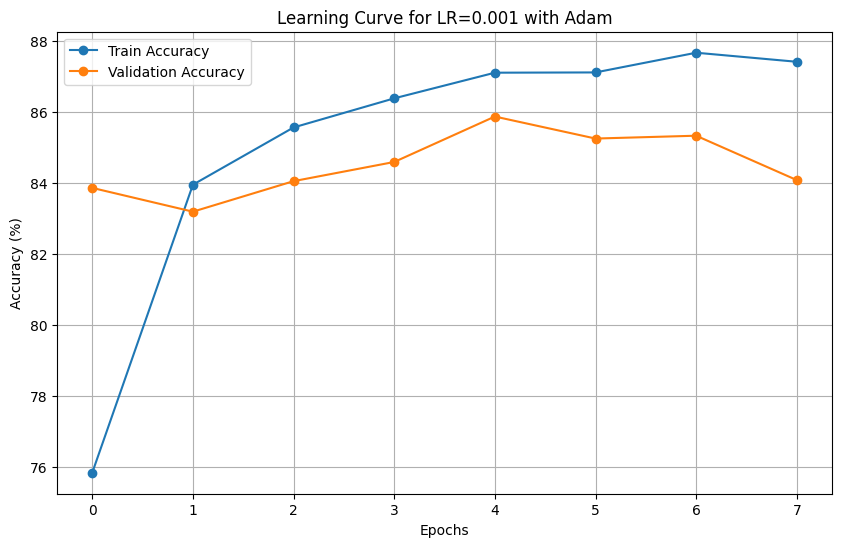

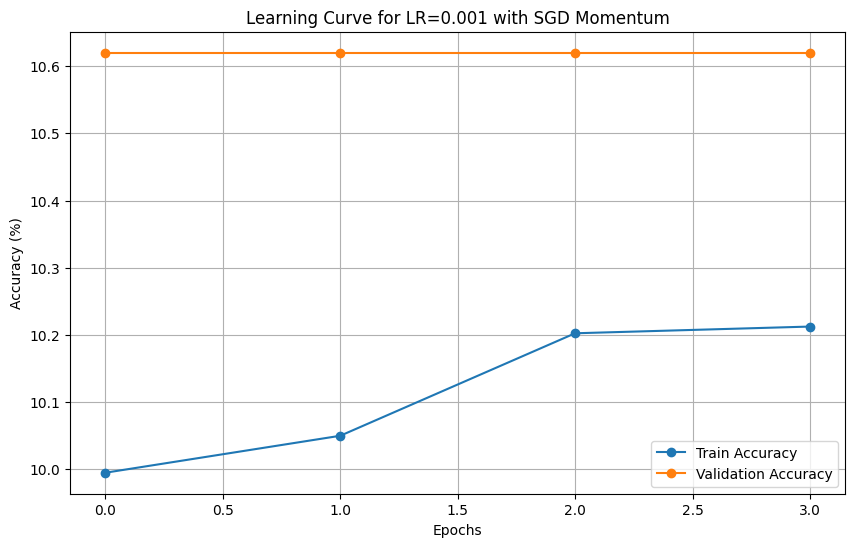

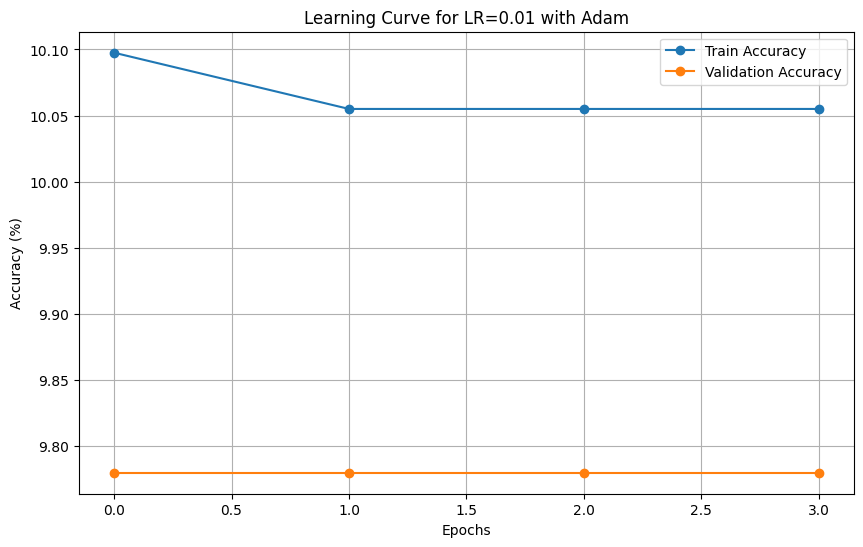

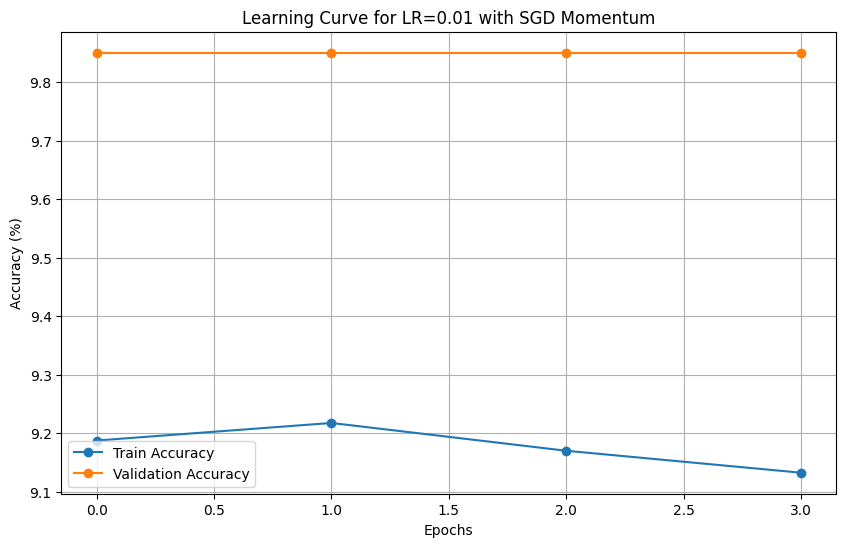

In [ ]:
for (lr, opt), (train_accs, valid_accs) in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Train Accuracy', marker='o')
    plt.plot(valid_accs, label='Validation Accuracy', marker='o')
    plt.title(f'Learning Curve for LR={lr} with {opt}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()


In [ ]:
import pandas as pd

data = []

for (lr, opt), (train_accs, valid_accs) in results.items():
    final_train_acc = train_accs[-1]
    final_valid_acc = valid_accs[-1]
    data.append([lr, opt, final_train_acc, final_valid_acc])

df_results = pd.DataFrame(data, columns=['Learning Rate', 'Optimizer', 'Final Train Accuracy', 'Final Validation Accuracy'])

In [ ]:
df_results

,Learning Rate,Optimizer,Final Train Accuracy,Final Validation Accuracy
0,0.001,Adam,87.4225,84.09
1,0.001,SGD Momentum,10.2125,10.62
2,0.010,Adam,10.0550,9.78
3,0.010,SGD Momentum,9.1325,9.85


## 5) Re-Train Model with the Best Hyper-Parameters







In [ ]:
results = {}

lr = 0.001
EPOCHS=10
model = VGG16Transfer(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

tr_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]

patience = 3
stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader)
    valid_loss, valid_acc = validate(model, criterion, valid_loader)
    tr_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        best_model_weights = model.state_dict()
        stopping_counter = 0
    else:
        stopping_counter += 1

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Epoch {epoch+1}/{EPOCHS}, Time: {elapsed_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.2f}%")
    print('-'*30)


    if stopping_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        model.load_state_dict(best_model_weights)
        break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Time: 278.55s
Train Loss: 1.7015, Train Accuracy: 76.04%
Validation Loss: 1.6255, Validation Accuracy: 83.73%
------------------------------
Epoch 2/10, Time: 279.64s
Train Loss: 1.6192, Train Accuracy: 84.14%
Validation Loss: 1.6109, Validation Accuracy: 85.10%
------------------------------
Epoch 3/10, Time: 279.63s
Train Loss: 1.6049, Train Accuracy: 85.62%
Validation Loss: 1.6098, Validation Accuracy: 85.17%
------------------------------
Epoch 4/10, Time: 276.38s
Train Loss: 1.5976, Train Accuracy: 86.33%
Validation Loss: 1.6087, Validation Accuracy: 85.34%
------------------------------
Epoch 5/10, Time: 275.94s
Train Loss: 1.5978, Train Accuracy: 86.27%
Validation Loss: 1.6210, Validation Accuracy: 84.17%
------------------------------
Epoch 6/10, Time: 277.04s
Train Loss: 1.5954, Train Accuracy: 86.51%
Validation Loss: 1.6178, Validation Accuracy: 84.44%
------------------------------
Epoch 7/10, Time: 278.88s
Train Loss: 1.5986, Train Accuracy: 86.19%
Validation Lo

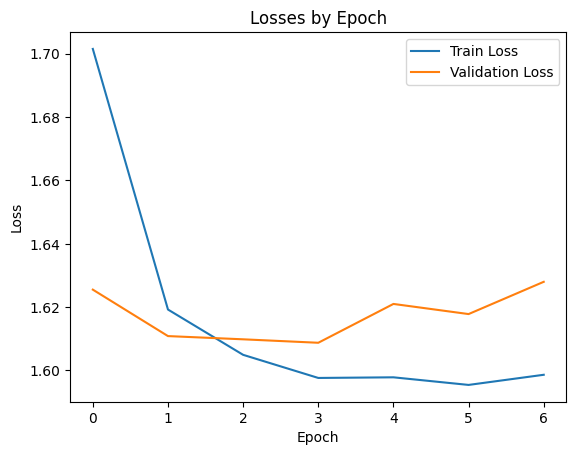

In [ ]:
plt.plot(tr_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Losses by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


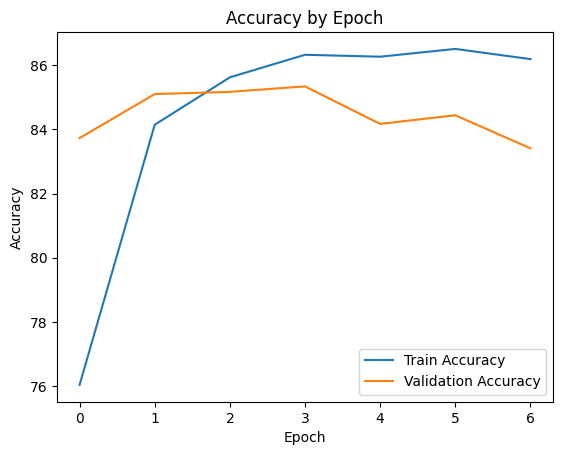

In [ ]:

plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 6)Test Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
model = VGG16Transfer(num_classes=10).cuda()
model.load_state_dict(best_model_weights)
model.eval()

all_preds = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# See various performance metrics
print(classification_report(all_labels, all_preds, target_names=raw_dataset.classes))

              precision    recall  f1-score   support

    airplane       0.77      0.93      0.84      1000
  automobile       0.95      0.88      0.91      1000
        bird       0.73      0.83      0.78      1000
         cat       0.69      0.76      0.72      1000
        deer       0.86      0.71      0.78      1000
         dog       0.94      0.56      0.70      1000
        frog       0.92      0.86      0.89      1000
       horse       0.75      0.92      0.83      1000
        ship       0.91      0.90      0.91      1000
       truck       0.89      0.92      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



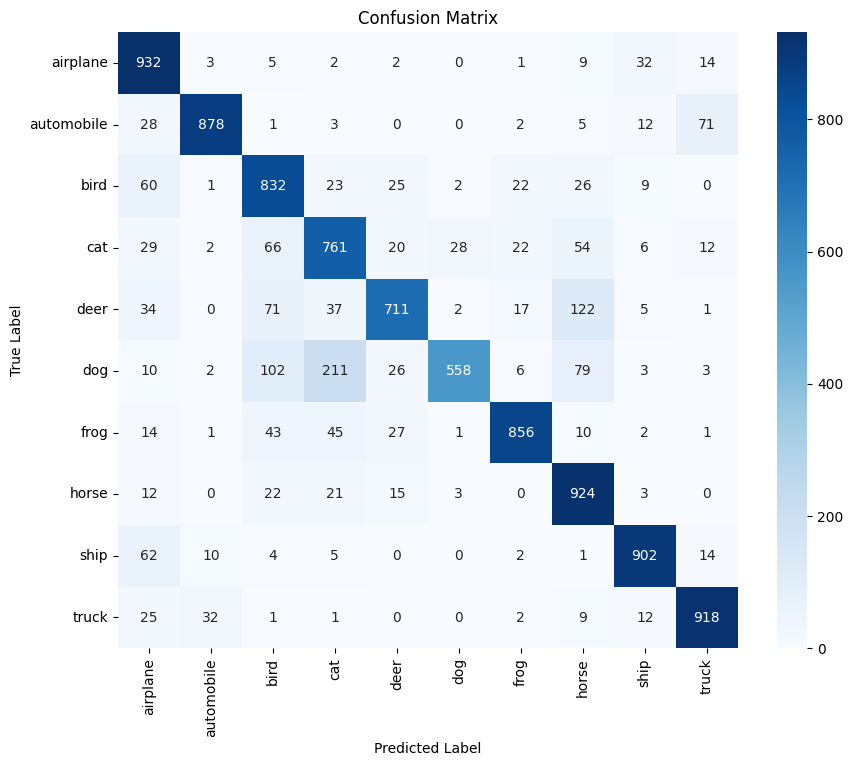

In [ ]:
# Plotting the Confusion Matrix
confusion_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=raw_dataset.classes,
            yticklabels=raw_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()